The Monet and Photo dataset for the Kaggle competition is a dataset of Monet paintings and photos that can be used to train a GAN model. I selected CycleGAN, which is a deep learning model that can be used to generate images, by converting photos images to a monet style images.

The Monet and Photo dataset contains the following:

300 Monet paintings
7,000+ photos

The photos in the dataset are a variety of different subjects, including landscapes, portraits, and still lifes.

The Monet paintings in the dataset are also a variety of different subjects, but they are all characterized by their distinctive style.

My goal is then to train a CycleGAN model whcih can translate photos into Monet paintings and Monet paintings into photos.  I will develop two models for this conversion.  Kaggle will then evaluate the generated images using MiFID (Memorization-informed Fréchet Inception Distance) scoring process.

The Monet and Photo dataset is a challenging dataset because it is relatively small and there is no paired training data.


CycleGAN models are trained using a technique called adversarial learning. In adversarial learning, two models are trained simultaneously.  One, the generator model and two, the discriminator model. The generator model is trained to generate images that can fool the discriminator model into thinking they are real images. The discriminator model is trained to distinguish btw real and generated images. The cycleGAN model uses cycle consistency during training, which helps to produce more realistic and accurate generated images.

In [ ]:
# import required libraries
import random
import sys
import zipfile
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import torch
import os

#Check for Nvidia Boom Stock GPUs!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#Load Datasets monet and photos
TRAIN_PATH_A = './datasets/data/gan-getting-started/monet_jpg/' #monet
TRAIN_PATH_B = './datasets/data/gan-getting-started/photo_jpg/' #photo

#TEST_PATH_A = './datasets/data/testA/'
#TEST_PATH_B = './datasets/data/testB/'
TRAIN_PATH_A

'./datasets/data/gan-getting-started/monet_jpg/'

In [ ]:
#gets the list of all the files in the TRAIN_PATH_A and TRAIN_PATH_B directories, and assigns them to the train_files_A and train_files_B variables
train_files_A = next(os.walk(TRAIN_PATH_A))[2]
train_files_B = next(os.walk(TRAIN_PATH_B))[2]

#test_files_A = next(os.walk(TEST_PATH_A))[2]
#test_files_B = next(os.walk(TEST_PATH_B))[2]
print(len(train_files_A))

300


In [ ]:
#Checking training data shape
demo = imread(TRAIN_PATH_A + train_files_A[0])
print(demo.shape)

(256, 256, 3)


In [ ]:
#Get training images
X_train_A = np.zeros((len(train_files_A), 256, 256, 3), dtype = np.uint8)
X_train_B = np.zeros((len(train_files_B), 256, 256, 3), dtype = np.uint8)

#X_test_A = np.zeros((len(test_files_A), 256, 256, 3), dtype = np.uint8)
#X_test_B = np.zeros((len(test_files_B), 256, 256, 3), dtype = np.uint8)

print('Getting training images from set A...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_files_A), total = len(train_files_A)):
  img_path = TRAIN_PATH_A + id_
  img = imread(img_path)[:, :, :3]
  X_train_A[n] = img

print('Getting training images from set B...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_files_B), total = len(train_files_B)):
  img_path = TRAIN_PATH_B + id_
  img = imread(img_path)[:, :, :3]
  X_train_B[n] = img

print('Getting testing images from set A...')
sys.stdout.flush()
'''
for n, id_ in tqdm(enumerate(test_files_A), total = len(test_files_A)):
  img_path = TEST_PATH_A + id_
  img = imread(img_path)[:, :, :3]
  X_test_A[n] = img

print('Getting testing images from set B...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_files_B), total = len(test_files_B)):
  img_path = TEST_PATH_B + id_
  img = imread(img_path)[:, :, :3]
  X_test_B[n] = img
'''
print('Done!')

Getting training images from set A...


100%|██████████| 300/300 [00:00<00:00, 944.21it/s]

Getting training images from set B...



100%|██████████| 7038/7038 [00:07<00:00, 988.51it/s] 

Getting testing images from set A...
Done!


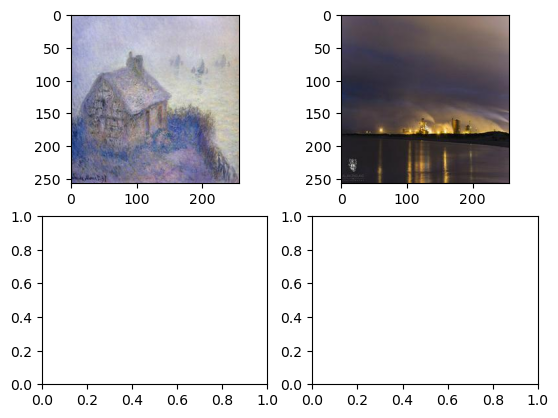

In [ ]:
#Show 2 images per folder
fig, axis = plt.subplots(2, 2)
axis[0][0].imshow(X_train_A[0].astype(np.uint8))
axis[0][1].imshow(X_train_B[0].astype(np.uint8))
#axis[1][0].imshow(X_test_A[0].astype(np.uint8))
#axis[1][1].imshow(X_test_B[0].astype(np.uint8))

In [ ]:
#Sanity check of shapes
print(X_train_A.shape)
print(X_train_B.shape)
#print(X_test_A.shape)
#print(X_test_B.shape)


(300, 256, 256, 3)
(7038, 256, 256, 3)


In [ ]:
#Random Jitter Using Data Augmentation

class pix2pix(Dataset):
    def __init__(self, input_imgs_np):
        self.input_imgs_np = input_imgs_np

    def transform(self, input_img_np):
        input_img = TF.to_pil_image(input_img_np)
        input_img = TF.resize(input_img, (286, 286))

        random_crop = transforms.RandomCrop((256, 256))
        input_img = random_crop(input_img)

        if random.random() > 0.5:
            input_img = TF.hflip(input_img)

        input_tensor = TF.to_tensor(input_img)
        return input_tensor

    def __len__(self):
        return len(self.input_imgs_np)

    def __getitem__(self, idx):
        input_img_np = self.input_imgs_np[idx]
        input_tensor = self.transform(input_img_np)
        return input_tensor

In [ ]:
train_dataset_A = pix2pix(X_train_A)
train_loader_A = DataLoader(train_dataset_A, batch_size = 1, shuffle = True)

train_dataset_B = pix2pix(X_train_B)
train_loader_B = DataLoader(train_dataset_B, batch_size = 1, shuffle = True)

In [ ]:
#Passing Data to list

train_A = []
train_B = []

for img in train_loader_A:
  train_A.append(img)

for img in train_loader_B:
  train_B.append(img)

In [ ]:
print(len(train_A))
print(train_A[0].shape)

300
torch.Size([1, 3, 256, 256])


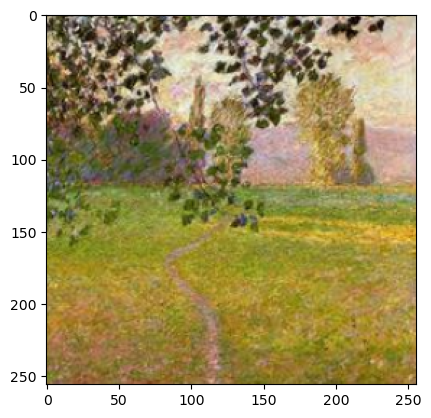

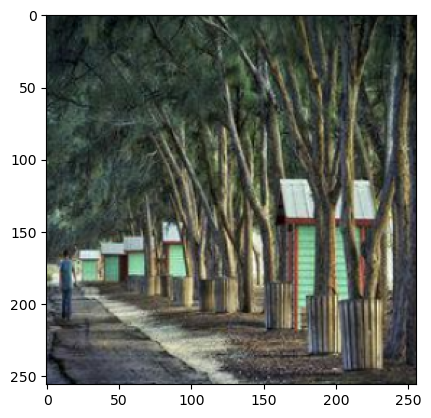

In [ ]:
#convert and show the images
x_np = np.array(TF.to_pil_image(train_A[0][0]))
plt.imshow(x_np)
plt.show()

x_np = np.array(TF.to_pil_image(train_B[0][0]))
plt.imshow(x_np)
plt.show()

In [ ]:
#Weight Initialization from Normal distribution
def weight_init(instance):
    classname = instance.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(instance.weight.data, 0.0, 0.02)
        nn.init.constant_(instance.bias.data, 0.0)

In [ ]:
#Convolutional & Fractional Convolution Blocks With ReLU Activation
def conv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.ReLU()
  )

def deconv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
#Resnet Module

class resnet(nn.Module):
  def __init__(self, in_channels, n_filters):
    super().__init__()
    self.conv_block_1 = conv_block(in_channels, n_filters, kernel_size = (3, 3), padding = 1, padding_mode = 'reflect')
    self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size = (3, 3), padding = 1, padding_mode = 'reflect')
    self.conv_2_in = nn.InstanceNorm2d(n_filters)

  def forward(self, x):
    c = self.conv_block_1(x)
    c = self.conv_2(c)
    c = self.conv_2_in(c)
    out = torch.cat((c, x), axis = 1)
    return out

This generator is part of the cycleGAN architecture, given the typical naming convention. This model is geared towards image-to-image translation task this HW requirements.


This architecture's generator model contains an encoder-decoder structure with a composed of residual blocks bootleneck. The encoder reduces the spatial dimension of the input while increasing the depth (channels). The bottleneck captures complex representations and then the decoder upscales these representations back to the original spatial dimensions.



1. The model is subclassed from nn.Module, which is the base class for all neural network modules in PyTorch.

2. Three convolutional layers are defined in sequence, where each convolution is presumably followed by some normalization and activation function. This is inferred from the use of conv_block, although the exact layers within conv_block are not provided.


3. The first layer expects an input with 3 channel, which is the RGB image, and outputs 64 channels.

4. The use of InstanceNorm2d and Tanh activation function indicates that the output image pixel values will be in the range [-1, 1].

5. The method defines the forward pass of the network.
The input x is passed through the convolutional blocks, then the residual blocks, and finally the deconvolutional blocks.
The processed output is then returned.



In [ ]:
#Generator
class generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_blocks = nn.Sequential(
        conv_block(3, 64, kernel_size = (7, 7), padding = 3, padding_mode = 'reflect'),
        conv_block(64, 128, kernel_size = (3, 3), stride = 2, padding = 1, padding_mode = 'reflect'),
        conv_block(128, 256, kernel_size = (3, 3), stride = 2, padding = 1, padding_mode = 'reflect'),
    )

    self.resnet_blocks = nn.Sequential(
        resnet(256, 256),
        resnet(512, 256),
        resnet(768, 256),
        resnet(1024, 256),
        resnet(1280, 256),
        resnet(1536, 256),
        resnet(1792, 256),
        resnet(2048, 256),
        resnet(2304, 256)
      )

    self.deconv_blocks = nn.Sequential(
        deconv_block(2560, 128, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1),
        deconv_block(128, 64, kernel_size = (3, 3), stride = 2, padding = 1, output_padding = 1),
        nn.Conv2d(64, 3, kernel_size = (7, 7), padding = 3, padding_mode = 'reflect'),
        nn.InstanceNorm2d(3),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.conv_blocks(x)

    x = self.resnet_blocks(x)

    out = self.deconv_blocks(x)

    return out


In [ ]:
#initialize the generator
#Creating generator objects
gen_AtoB = generator()
gen_AtoB = gen_AtoB.float()
gen_AtoB = gen_AtoB.to(device)
gen_AtoB.apply(weight_init)

gen_BtoA = generator()
gen_BtoA = gen_BtoA.float()
gen_BtoA = gen_BtoA.to(device)
gen_BtoA.apply(weight_init)

#Printing one instance
print(gen_AtoB)

#Total trainable params
total_params = sum(p.numel() for p in gen_AtoB.parameters() if p.requires_grad)
print(total_params)

generator(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_blocks): Sequential(
    (0): resnet(
      (conv_block_1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, mom

In [ ]:
#Convolutional Block with Leaky RELU
def conv_block_leaky(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.InstanceNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

This is the discriminator part of the cycleGAN. The role of the discriminator in GANs is to distinguish between real and generated samples.

This discriminator model is a CNN-based classifier that processes input images and outputs a probability score indicating whether the input is a real or generated image. The generator tries to produce images that the discriminator cannot distinguish from real images, while the discriminator aims to become better at distinguishing between the two.

In [ ]:
#Discriminator Model
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = (4, 4), stride = 2, padding = 1),
        nn.LeakyReLU(negative_slope = 0.2)
    )

    self.conv_blocks = nn.Sequential(
        conv_block_leaky(64, 128, kernel_size = (4, 4), stride = 2, padding = 1),
        conv_block_leaky(128, 256, kernel_size = (4, 4), stride = 2, padding = 1),
        nn.ZeroPad2d(1),
        conv_block_leaky(256, 512, kernel_size = (4, 4), stride = 1)
    )

    self.conv_block_last = nn.Sequential(
        nn.ZeroPad2d(1),
        nn.Conv2d(512, 1, kernel_size = (4, 4), stride = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_block_1(x)

    x = self.conv_blocks(x)

    out = self.conv_block_last(x)

    return out

In [ ]:
#Creating discriminator objects
disc_A = discriminator()
disc_A = disc_A.float()
disc_A = disc_A.to(device)
disc_A.apply(weight_init)

disc_B = discriminator()
disc_B = disc_B.float()
disc_B = disc_B.to(device)
disc_B.apply(weight_init)

#Printing one instance
print(disc_A)

#Total trainable params
total_params = sum(p.numel() for p in disc_A.parameters() if p.requires_grad)
print(total_params)

discriminator(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): ZeroPad2d((1, 1, 1, 1))
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (conv_block_last): Sequential(
    (0): ZeroPad2d((1, 1

The mean squared error loss computes the average of the squared differences between the generated outputs that was processed by the discriminator and the target tensor of ones.

In [ ]:
#Adversarial Losses
def gen_loss_gan(gen_disc_out):
  target = torch.ones((gen_disc_out.shape[0], 1, 30, 30)).to(device)
  loss = nn.MSELoss()(gen_disc_out.float(), target.float())
  return loss

def disc_loss_gan(real_out, fake_out):
  real_target = torch.ones((real_out.shape[0], 1, 30, 30)).to(device)
  fake_target = torch.zeros((fake_out.shape[0], 1, 30, 30)).to(device)
  real_loss = nn.MSELoss()(real_out.float(), real_target.float())
  fake_loss = nn.MSELoss()(fake_out.float(), fake_target.float())
  total_loss = (real_loss + fake_loss)/2.0
  return total_loss

The Cycle consistency loss of  CycleGAN help tracks that when an image from domain monet is translated to domain photo and then translated back to domain monet, the retranslated image should be close to the original image from domain monet.

In [ ]:
#Cycle consistency Loss
def cycle_loss(orig, regen):
  loss = nn.L1Loss()(regen.float(), orig.float())
  return loss

In [ ]:
#Training Data Generator

def generate_real_sample(dataset):
  idx = random.randint(0, len(dataset) - 1)
  return dataset[idx]

def generate_fake_sample(gen_obj, img_obj):
  img_obj = img_obj.to(device)
  fake_img = gen_obj(img_obj.float())
  return fake_img

In [ ]:
out_sample = generate_fake_sample(gen_AtoB, train_A[0])
print(isinstance(train_A[0], torch.Tensor))
print(isinstance(out_sample, torch.Tensor))

True
True


/home/olu/miniconda3/envs/rapids-23.08/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),


In [ ]:
#Image Pool
def update_pool(pool, image):

  if len(pool) < 50:
    pool.append(image)
    return image

  else:
    if random.random() > 0.5:
      p = random.randint(0, len(pool) - 1)
      tmp = pool[p]
      pool[p] = image
      return tmp

    else:
      return image


In [ ]:
#Defining Optimizer
gen_opt_AtoB = optim.Adam(gen_AtoB.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt_BtoA = optim.Adam(gen_BtoA.parameters(), lr = 0.0002, betas = (0.5, 0.999))

disc_opt_A = optim.Adam(disc_A.parameters(), lr = 0.0002, betas = (0.5, 0.999))
disc_opt_B = optim.Adam(disc_B.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
#define the training function
def train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, num_epochs, Lambda):

  gen_AtoB_losses = []
  gen_BtoA_losses = []
  disc_A_losses = []
  disc_B_losses = []

  gen_AtoB.train()
  gen_BtoA.train()
  disc_A.train()
  disc_B.train()

  sample_img_A = train_A[0].to(device)
  sample_img_B = train_B[0].to(device)

  for epoch in range(num_epochs + 1):

    gen_AtoB_total = 0
    gen_BtoA_total = 0
    disc_A_total = 0
    disc_B_total = 0

    pool_A = []
    pool_B = []

    for _ in range(len(train_A)):

      real_A = generate_real_sample(train_A)
      real_A = real_A.to(device)
      real_B = generate_real_sample(train_B)
      real_B = real_B.to(device)

      fake_A = generate_fake_sample(gen_BtoA, real_B)
      fake_B = generate_fake_sample(gen_AtoB, real_A)

      #Discriminator A training
      disc_opt_A.zero_grad()

      real_disc_A_out = disc_A(real_A.float())
      fake_disc_A_in = fake_A.detach()
      fake_disc_A_in = update_pool(pool_A, fake_disc_A_in)

      fake_disc_A_out = disc_A(fake_disc_A_in.float())
      disc_loss_A = disc_loss_gan(real_disc_A_out, fake_disc_A_out)
      disc_A_total += disc_loss_A

      disc_loss_A.backward()
      disc_opt_A.step()

      #Discriminator B training
      disc_opt_B.zero_grad()

      real_disc_B_out = disc_B(real_B.float())
      fake_disc_B_in = fake_B.detach()
      fake_disc_B_in = update_pool(pool_B, fake_disc_B_in)

      fake_disc_B_out = disc_A(fake_disc_B_in.float())
      disc_loss_B = disc_loss_gan(real_disc_B_out, fake_disc_B_out)
      disc_B_total += disc_loss_B

      disc_loss_B.backward()
      disc_opt_B.step()

      #Generator AtoB training
      gen_opt_AtoB.zero_grad()

      real_fake_out_B = disc_B(fake_B.float())                 #Calculating adversarial loss
      gen_AtoB_gan_loss = gen_loss_gan(real_fake_out_B)

      fake_A_detach = fake_A.detach()                          #Calculating cyclic consistency loss
      recon_B = generate_fake_sample(gen_AtoB, fake_A_detach)
      gen_AtoB_cyc_loss = cycle_loss(real_B, recon_B)

      gen_AtoB_loss = gen_AtoB_gan_loss + Lambda*gen_AtoB_cyc_loss
      gen_AtoB_total += gen_AtoB_loss

      gen_AtoB_loss.backward()
      gen_opt_AtoB.step()

      #Generator BtoA training
      gen_opt_BtoA.zero_grad()

      real_fake_out_A = disc_A(fake_A.float())                  #Calculating adversarial loss
      gen_BtoA_gan_loss = gen_loss_gan(real_fake_out_A)

      fake_B_detach = fake_B.detach()                           #Calculating cyclic consistency loss
      recon_A = generate_fake_sample(gen_BtoA, fake_B_detach)
      gen_BtoA_cyc_loss = cycle_loss(real_A, recon_A)

      gen_BtoA_loss = gen_BtoA_gan_loss + Lambda*gen_BtoA_cyc_loss
      gen_BtoA_total += gen_BtoA_loss

      gen_BtoA_loss.backward()
      gen_opt_BtoA.step()

    gen_AtoB_losses.append(gen_AtoB_total)
    gen_BtoA_losses.append(gen_BtoA_total)
    disc_A_losses.append(disc_A_total)
    disc_B_losses.append(disc_B_total)

    print('Epoch ', epoch, ' - ', 'Gen_A2B_Loss = ', gen_AtoB_total/len(train_A), ' Gen_B2A_Loss = ', gen_BtoA_total/len(train_A))
    sys.stdout.flush()
    print('Disc_A_Loss = ', disc_A_total/len(train_A), ' Disc_B_Loss = ', disc_B_total/len(train_A))
    sys.stdout.flush()

    #Printing a set of images to monitor progress every 5 epochs
    '''
    if epoch % 5 == 0:
      gen_AtoB.eval()
      sample_out_B = gen_AtoB(sample_img_A.float())
      gen_AtoB.train()

      gen_BtoA.eval()
      sample_out_A = gen_BtoA(sample_img_B.float())
      gen_BtoA.train()

      sample_img_A = sample_img_A.cpu()
      sample_img_B = sample_img_B.cpu()
      sample_out_A = sample_out_A.cpu()
      sample_out_B = sample_out_B.cpu()

      sample_img_A_np = np.array(TF.to_pil_image(sample_img_A[0]))
      sample_img_B_np = np.array(TF.to_pil_image(sample_img_B[0]))
      sample_out_A_np = np.array(TF.to_pil_image(sample_out_A[0]))
      sample_out_B_np = np.array(TF.to_pil_image(sample_out_B[0]))

      fig, axis = plt.subplots(2, 2)
      axis[0][0].imshow(sample_img_A_np.astype(np.uint8))
      axis[0][0].axis('off')
      axis[1][0].imshow(sample_out_B_np.astype(np.uint8))
      axis[1][0].axis('off')
      axis[0][1].imshow(sample_img_B_np.astype(np.uint8))
      axis[0][1].axis('off')
      axis[1][1].imshow(sample_out_A_np.astype(np.uint8))
      axis[1][1].axis('off')
      plt.show()
      '''


In [ ]:
#Start the training process
num_epochs = 100
Lambda = 10
train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, num_epochs, Lambda)

Epoch  0  -  Gen_A2B_Loss =  tensor(3.1176, device='cuda:0', grad_fn=<DivBackward0>)  Gen_B2A_Loss =  tensor(4.5915, device='cuda:0', grad_fn=<DivBackward0>)
Disc_A_Loss =  tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>)  Disc_B_Loss =  tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1  -  Gen_A2B_Loss =  tensor(3.0078, device='cuda:0', grad_fn=<DivBackward0>)  Gen_B2A_Loss =  tensor(4.6623, device='cuda:0', grad_fn=<DivBackward0>)
Disc_A_Loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)  Disc_B_Loss =  tensor(2.4996e-05, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2  -  Gen_A2B_Loss =  tensor(2.9462, device='cuda:0', grad_fn=<DivBackward0>)  Gen_B2A_Loss =  tensor(4.6035, device='cuda:0', grad_fn=<DivBackward0>)
Disc_A_Loss =  tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>)  Disc_B_Loss =  tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3  -  Gen_A2B_Loss =  tensor(2.9073, device='cuda:0', grad_fn=<DivBackward0>)  Gen_B2A

As the epochs progress, the losses appear to decrease which is typically a good sign in training neural networks. However, without knowing the exact architecture and goal of the GAN, it's hard to definitively say how well the training is going. But it's noteworthy that some of the discriminator losses become exceedingly small (close to zero), which could be an indication that the discriminator is performing very well, or it could be a sign of the generator not learning effectively, leading to mode collapse. This is something to keep an eye on.

In [ ]:
#Save model
torch.save(gen_AtoB.state_dict(), './models/gen_AtoB_model.pth')


In [ ]:
#Generate the images for kaggle submission.
gen_AtoB = generator()
gen_AtoB = gen_AtoB.to(device)
gen_AtoB.load_state_dict(torch.load('./models/gen_AtoB_model.pth'))
gen_AtoB.eval()
monet_loader = DataLoader(train_files_B, batch_size=1)

#Create folder to save the images
output_dir = 'generated_photos'
os.makedirs(output_dir, exist_ok=True)


transform = ToTensor()

for i, monet_image_filename in enumerate(monet_loader):
    if i >= 7030:
        break


    image_path = os.path.join(TRAIN_PATH_B, monet_image_filename[0])
    pil_image = Image.open(image_path)
    tensor_image = transform(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_photo = gen_AtoB(tensor_image)

    save_image(generated_photo, os.path.join(output_dir, f'generated_photo_{i}.png'))

print(f'Generated {i+1} photos and saved to {output_dir}')



Generated 7031 photos and saved to generated_photos


In [2]:
#!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


Hyperparameter search using optuna.

In [ ]:
import optuna

def objective(trial):
    # Define hyperparameter search space
    lr_gen = trial.suggest_float('lr_gen', 1e-5, 1e-3, log=True)
    lr_disc = trial.suggest_float('lr_disc', 1e-5, 1e-3, log=True)
    Lambda = trial.suggest_float('Lambda', 5, 20, step=1)

    # (Re)initialize networks and optimizers with suggested hyperparameters
    #gen_AtoB = generator()
    #gen_AtoB = gen_AtoB.to(device)

    gen_AtoB = generator().to(device)
    gen_BtoA = generator().to(device)
    disc_A = discriminator().to(device)
    disc_B = discriminator().to(device)
    gen_opt_AtoB = torch.optim.Adam(gen_AtoB.parameters(), lr=lr_gen, betas=(0.5, 0.999))
    gen_opt_BtoA = torch.optim.Adam(gen_BtoA.parameters(), lr=lr_gen, betas=(0.5, 0.999))
    disc_opt_A = torch.optim.Adam(disc_A.parameters(), lr=lr_disc, betas=(0.5, 0.999))
    disc_opt_B = torch.optim.Adam(disc_B.parameters(), lr=lr_disc, betas=(0.5, 0.999))

    # Training the model
    train(gen_AtoB, gen_BtoA, disc_A, disc_B, gen_opt_AtoB, gen_opt_BtoA, disc_opt_A, disc_opt_B, train_A, train_B, num_epochs, Lambda)


    return gen_AtoB_losses[-1].item()

# Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('new hyperparameters: ', study.best_params)
